<a href="https://colab.research.google.com/github/RealMyeong/Going_Deeper_NLP/blob/main/OnlyCode/Transformer_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이번 코스는 트랜스포머를 완성하는 데에 필요한 모듈들을 하나하나 만든 후, 조립하여 완성하는 방식으로 진행할 겁니다.

자, Tensor로 변환한 입력 데이터가 주어졌다고 가정하고 흐름을 생각해 봅시다. 최초의 텍스트 입력 데이터는 [ batch_size x length ] 의 형태를 가지고 있겠죠? 번역이 끝나고 난 최종 출력 데이터는 [ batch_size x length x vocab_size ]의 형태를 가지게 됩니다. 번역 문제는 결국 매 스텝마다 vocab_size 만큼의 클래스 개수 중에 적당한 단어를 선택하는 작업을 length만큼 반복하는 것이니까요. 모델 구성하는 과정에서 레이어를 통과할 때마다 텐서의 shape가 어떻게 바뀌는지를 눈여겨봅시다.

- length : 문장의 길이(토큰의 개수)

1. 입력 데이터 → [ batch_size x length ]  
2. Source & Target Embedding → [ batch_size x length x d_emb ]  
3. Positional Encoding 강의 노드에서 구현을 했었죠? 2번의 결과에 더해지므로 shape 변화는 없습니다.  
4. Multi-Head Attention 아래와 같이 여러 개의 서브 모듈들이 존재합니다.  
  1. Split Heads →[ batch_size x length x heads x (d_emb / n_heads) ]  
  2. Masking for Masked Attention  
  3. Scaled Dot Product Attention  
  4. Combine Heads →[ batch_size x length x d_emb ]  
  
5. Residual Connection  
6. Layer Normalization  
7. Position-wise Feed-Forward Network → [ batch_size x length x d_ff ]  
8. Output Linear Layer → [ batch_size x length x vocab_size ]

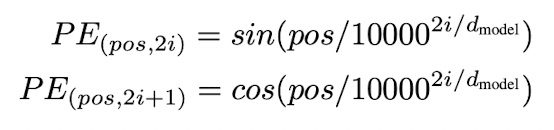

In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


In [8]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*int(i)) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    # 짝수 인덱스에는 sin함수 적용
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 홀수 인덱스에는 cos함수 적용
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table


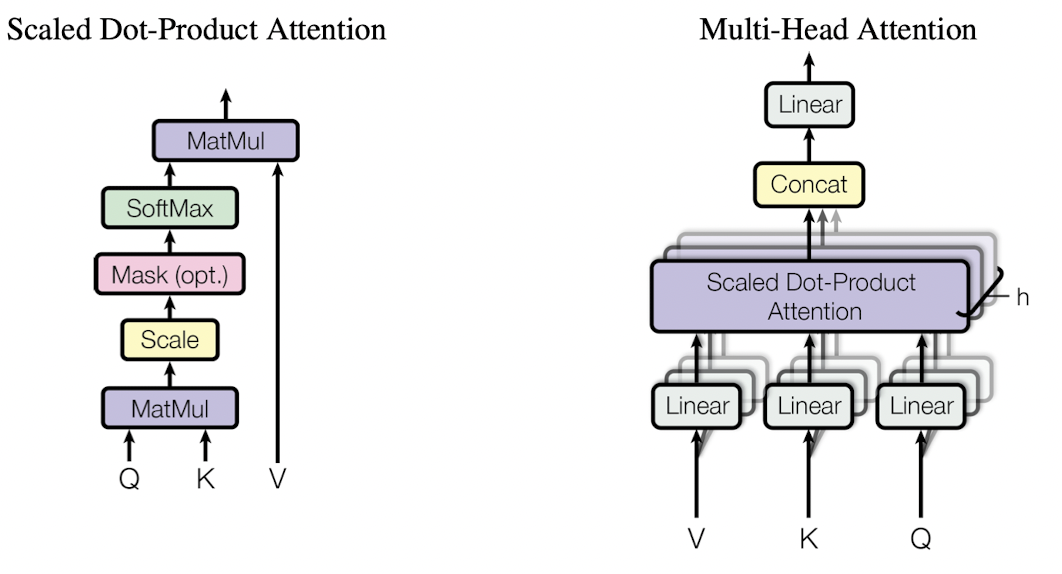

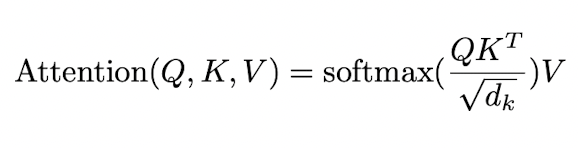

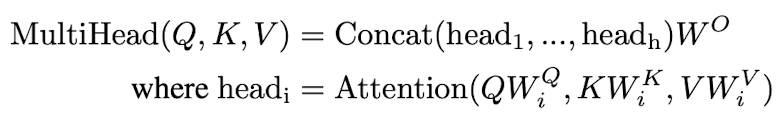

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # 나눌 헤드의 개수
        self.num_heads = num_heads
        self.d_model = d_model
        # 헤드 당 차원의 크기
        self.depth = d_model // self.num_heads
        # Q, K, V 가중치
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        # Q K^T 계산

        QK = tf.matmul(Q, K, transpose_b=True)
        
        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        # x.shape = (batch_size, length, d_model)
        batch_size = x.shape[0]
        # split_x.shape = (batch_size, length, heads, (d_model / n_heads))
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3]) # 각 배치에 각 헤드당 (length X depth)가 있음.
                                                           # (batch_size, heads, length, depth)

        return split_x

    def combine_heads(self, x):
        # x.shape = (batch_size, heads, length, depth)
        batch_size = x.shape[0]
        # (batch_size, length, heads, depth)로 바꿔줌
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        # (batch_size, length, heads X depth)로 최종 변환 -> concat한 것.
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        # Q, K, V각각 linear transformation함.
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # 각각을 헤드 개수만큼 나눠줌 
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        

        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    		
        out = self.combine_heads(out)
        # 이 부분이 concat(head_1, ..., head_n) x WO 부분임.
        out = self.linear(out)
                
        return out, attention_weights

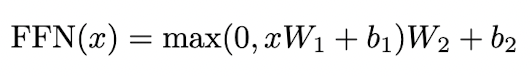

In [10]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

print("슝=3")

슝=3


```
N = 10

# 10개의 Linear Layer를 한 방에!
linear_layers = [tf.keras.layers.Dense(30) for _ in range(N)]

# 10개의 Encoder Layer도 한 방에!
enc_layers = [TransformerEncoderLayer(30) for _ in range(N)]
```

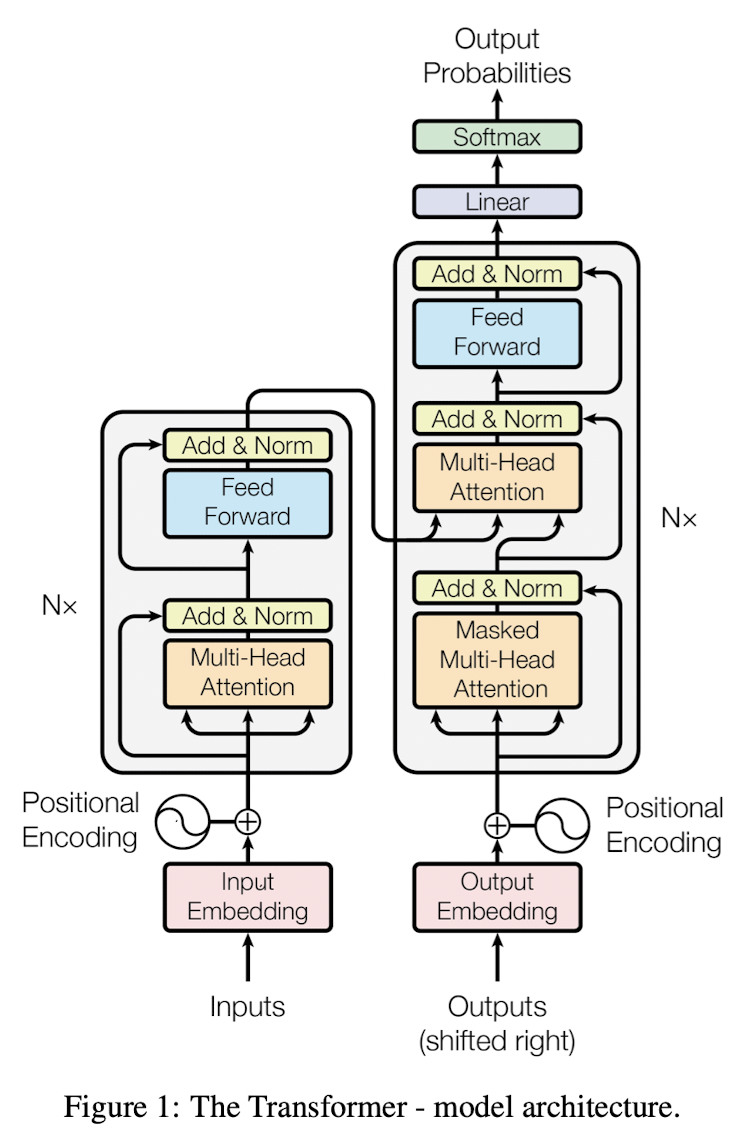

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        # Multi-Head Attention 계산
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        # residual connection 
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("슝=3")

슝=3


In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # 인코더의 output과 디코더 output을 입력으로 넣어주는 부분.
        # 마스킹을 통하여 leftward information flow를 유지해줌
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [13]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers, # 인코더 레이어의 개수
                 d_model, # input 차원
                 n_heads, # 헤드 몇개로 나눌것인지
                 d_ff, # feed forward net의 히든레이어 차원
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("슝=3")

슝=3


In [14]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("슝=3")

슝=3


In [15]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)
        # [length x d_model]로 된 positional_encoding의 반환값을
        # np.newaxis를 통해 [1 x length x d_model]로 바꿔줌 -> 브로드캐스팅을 가능하게 하기위해
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [16]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("슝=3")

슝=3


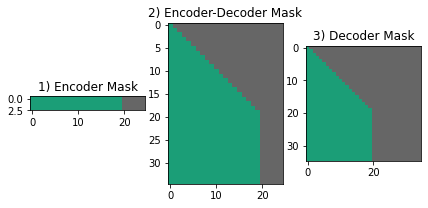

In [17]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [18]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("슝=3")

슝=3
